# M/M/1 queue with $H_{\theta}(p,q) = \mathbb{1}(q \leq Q_{\max})e^{-\theta_1 p -\theta_2 q}$
## We simulate $Q(w,a)$ values 

In [1]:
import math

import numpy as np
import pandas as pd

import scipy
from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape

import matplotlib.pyplot as plt

from collections import deque

import time

from statistics import mean 

In [2]:
###########################################################################################################################################################################################
# Simulation variables

# True arrival rate
global lam, theta_1, theta_2, s, Q_max

# Total customers that we shall generate
global n

############################################################################################################################################################################################
def generate_arrival_process(x): # x is the arrival rate
    global interarrival_times
    global arrival_times
    
    interarrival_times = np.random.exponential(1/x, n)
    arrival_times = np.cumsum(interarrival_times)
    arrival_times -= arrival_times[0]
    
###########################################################################################################################################################################################
def generate_service_times(x):
    global service_times
    global mean_service_time
    
    # Gamma distribution - mean = x[0]x[1] and variance = x[0]x[1]^2
    # mean_service_time = x[0]*x[1]
    # service_times = np.random.gamma(x[0], x[1], n)
    
    # Exponential distribution
    mean_service_time = 1/x
    service_times = np.random.exponential(1/x, n)
    
###########################################################################################################################################################################################
class Customer(): # Creating an object "Customer" with relevant information
    # Price paid by customer
    price_paid = 0
    
    # Time of arrival
    arrival_time = 0
    
    # Time of departure
    departure_time = 0
    
    # Time taken for servicing
    service_time = 0
    
    # Time spent waiting in queue (does not include service time)
    waiting_time = 0
    
    # Server number which served the customer
    server = 0
    
    # Does the customer join? 0 if yes, 1 if no
    joining_decision = 0
    
    # Customer number (basically assigned between 0 and n-1)
    number = 0
    
    # Observed number of customers in system upon arrival and before joining
    observed_queue_length = 0
    
    # Jump caused in virtual waiting time
    jump_virtual_waiting_time = 0
###########################################################################################################################################################################################

In [3]:
def joining_probability(q, p):
    return np.exp(-theta_1*p - theta_2*q)

    
def gradient_joining_probability(q, p):
    return np.exp(-theta_1*p - theta_2*q)*(-theta_1)


def evaluate_steady_state_distribution(par): # par = (price, lam, theta_1, theta_2)
    # Trims steady state distribution to {p0, p1, p2, ..., p_cutoff}
    global steady_state_distribution
    steady_state_distribution = np.ones(Q_max+1)
    
    for i in range(1, s+1):
        steady_state_distribution[i] = steady_state_distribution[i-1]*par[1]*mean_service_time*np.exp(-par[2]*par[0])/i
    for i in range(s+1, Q_max+1):
        steady_state_distribution[i] = steady_state_distribution[i-1]*par[1]*mean_service_time*np.exp(-par[2]*par[0]-par[3]*(i-s))/s
    
    steady_state_distribution = steady_state_distribution/np.sum(steady_state_distribution)
    return steady_state_distribution


def evaluate_derivative_steady_state_distribution_wrt_price(par): # par = (price, lam, theta_1, theta_2)
    delta = 1e-8
    derivative = (evaluate_steady_state_distribution([par[0]+delta/2, par[1], par[2], par[3]]) - evaluate_steady_state_distribution([par[0]-delta/2, par[1], par[2], par[3]]))/delta
    return derivative


def evaluate_revenue_given_price(par): # par = (price, lam, theta_1, theta_2)
    steady_state_distribution = evaluate_steady_state_distribution(par)
    revenue = par[0] * par[1] * np.exp(-par[2]*par[0]) * np.sum(np.exp(-par[3]*np.maximum(0, np.arange(Q_max+1)-s+1))*steady_state_distribution)
    return revenue

In [4]:
# Obtain Q-value for one sample path given fixed price p, R(p), initial state and initial action
# Basically, whatever is inside the expectation, for a fixed realization.

# Q(s,a) = \sum_{i=1}^{inf} E[r_i - R(p) | s_0 = s, a_0 = a] where r_i = lambda p a_i

def queue_simulation_1(initial_queue_length, initial_action, p, theoretical_revenue):

    # Simulation variables
    global customers
    global server_workloads
    global dynamic_queues
    global dynamic_residual_service_times
    
    # Post processing variables
    # global effective_arrival_times
    # global effective_interarrival_times
    # global departure_times
    # global waiting_times
    # global upward_jump_virtual_waiting_times
    
##################################################################################################################################    
    # Initialization
    customers = [Customer() for i in range(n)]
    
    if initial_queue_length == 0:
        server_workloads = 0
        dynamic_residual_service_times = 0
    else:
        service_times_existing_customers = np.random.exponential(lam, initial_queue_length)
        server_workloads = np.sum(service_times_existing_customers)
        dynamic_residual_service_times = service_times_existing_customers[0] # Keeps track of residual service times just after arrival events during the simulation
    
    # New variables to keep track of
    dynamic_queues = deque()

    # Relevant information to calculate and store
    # effective_arrival_times = []
    # effective_interarrival_times = []
    # departure_times = []
    # waiting_times = []
    # upward_jump_virtual_waiting_times = []
##################################################################################################################################   
    
    Q_value = 0
    price = p
    
    i = 0
    for cust in customers:
        # Storing customer information
        cust.number = i
        cust.arrival_time = arrival_times[i]
        cust.service_time = service_times[i]
        
        # Calculates number in system observed by incoming arrival
        cust.observed_queue_length = len(dynamic_queues)
        
        # Joining decision
        if i == 0:
            cust.waiting_time = server_workloads
            cust.joining_decision = initial_action
        else:
            cust.waiting_time = server_workloads
            joining_prob = joining_probability(cust.observed_queue_length, price)
            cust.joining_decision = np.random.binomial(1, joining_prob)
        
        Q_value += (lam*price*cust.joining_decision - theoretical_revenue)
        
        
        if cust.joining_decision == 1:
            dynamic_queues.append(i) # Customer joins queue corresponding to minimum workload server
            if len(dynamic_queues) == 1:
                dynamic_residual_service_times = cust.service_time

            # effective_arrival_times.append(cust.arrival_time)

            # cust.server = 1
            # cust.departure_time = cust.arrival_time + cust.waiting_time + cust.service_time
            
            # Jump in virtual waiting time calculation
            server_workloads += cust.service_time # Adds arriving customer's service time to minimum workload server
            # cust.jump_virtual_waiting_time = cust.service_time # Adding new virtual waiting time AFTER customer arrival

            # waiting_times.append(cust.waiting_time)
            # departure_times.append(cust.departure_time)
            # upward_jump_virtual_waiting_times.append(cust.jump_virtual_waiting_time)
        
            
        if i != n-1:
            # Time to update residual service times here. Mathematical formulation of the code is as follows:-
            # Suppose service times of a queue corresponding to a server are: 5(residual service time of customer being served),20,22,17,23,28,... and time since last arrival is 50,
            # Then, new queue becomes 14,23,28,... 
            for j in range(1):
                if len(dynamic_queues) == 0:
                    dynamic_residual_service_times = 0
                    continue
                
                time_until_next_arrival = arrival_times[i+1] - arrival_times[i]

                if time_until_next_arrival > dynamic_residual_service_times:
                    time_until_next_arrival -= dynamic_residual_service_times
                    dynamic_residual_service_times = 0
                    dynamic_queues.popleft()
                else:
                    dynamic_residual_service_times -= time_until_next_arrival
                    continue

                while len(dynamic_queues)!=0 and time_until_next_arrival > customers[dynamic_queues[0]].service_time:
                    time_until_next_arrival -= customers[dynamic_queues[0]].service_time
                    dynamic_queues.popleft()

                if len(dynamic_queues) == 0:
                    dynamic_residual_service_times = 0
                    continue
                else:
                    dynamic_residual_service_times = customers[dynamic_queues[0]].service_time - time_until_next_arrival
            
            
            server_workloads -= (arrival_times[i+1] - arrival_times[i]) # Subtracting time passed until next arrival from all server workloads
            server_workloads = max(server_workloads, 0)  # All those with workload < 0 are converted to 0
        
        i += 1

##################################################################################################################################
        
    # Post processing
    
#     effective_arrival_times = np.array(effective_arrival_times)
#     effective_interarrival_times = [effective_arrival_times[0]] + [j-i for i,j in zip(effective_arrival_times, effective_arrival_times[1:])]
#     effective_interarrival_times = np.array(effective_interarrival_times)
#     departure_times.sort()
#     departure_times = np.array(departure_times)
#     waiting_times = np.array(waiting_times)
#     upward_jump_virtual_waiting_times = np.array(upward_jump_virtual_waiting_times)
    
#     all_waiting_times = np.array(all_waiting_times)

    return Q_value

## Theoretical price dictionary

In [5]:
lam = 0.8
theta_1 = 0.1
theta_2 = 0.2
s = 1

Q_max = 20

service_par = 1
mean_service_time = 1/service_par

Optimal price from graph =  10.700000000000001
Maximum theoretical revenue =  2.770184534527252


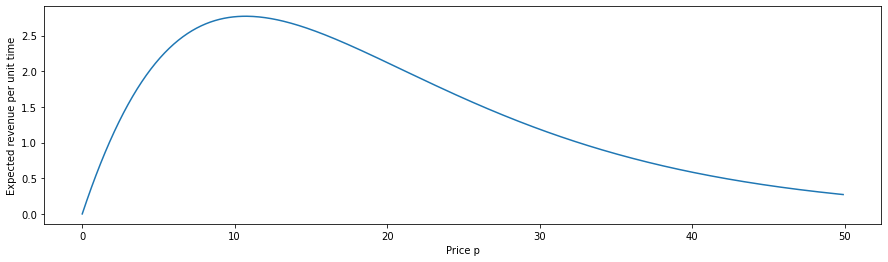

In [6]:
prices = np.arange(0, 50, 0.1)

# Theoretical optimal price to charge at the true parameters, and corresponding maximum revenue
optimal_price_theoretical = 0
max_revenue_theoretical = 0

revenues = []
for admission_price in prices:
    revenue_per_unit_time = evaluate_revenue_given_price([admission_price, lam, theta_1, theta_2])
    revenues.append(revenue_per_unit_time)
    if revenue_per_unit_time > max_revenue_theoretical:
        max_revenue_theoretical = revenue_per_unit_time
        optimal_price_theoretical = admission_price

plt.figure(figsize = (15,4))
plt.plot(prices, revenues)
plt.ylabel("Expected revenue per unit time")
plt.xlabel("Price p")

print("Optimal price from graph = ", optimal_price_theoretical)
print("Maximum theoretical revenue = ", max_revenue_theoretical)

In [7]:
# Evaluating R(p) for various prices using simulation

tuples = [(key, value) for i, (key, value) in enumerate(zip(prices, revenues))]
price_revenue_dict = dict(tuples)

## Studying the map $w \mapsto Q^p(w,a)$ for fixed price $p$ and action $a$.

In [9]:
lam = 0.8
theta_1 = 0.1
theta_2 = 0.2
s = 1

service_par = 1

price = 10
theoretical_revenue = price_revenue_dict[price]
print(theoretical_revenue)

2.7630686968446736


In [10]:
# Evaluation of simulated Q values

n = 1000000 # Number of customers per simulation run
N_runs = 200 # Number of simulations

initial_queue_length_vector = np.arange(0, 21, 1)

Q_values_joining_fixed_price = []
Q_values_not_joining_fixed_price = []

for initial_queue_length in initial_queue_length_vector:
    mean_Q_joining = 0
    mean_Q_not_joining = 0
    
    for iter in range(N_runs):
        generate_arrival_process(lam)
        generate_service_times(service_par)
        
        mean_Q_joining += queue_simulation_1(initial_queue_length, 1, price, theoretical_revenue)
        mean_Q_not_joining += queue_simulation_1(initial_queue_length, 0, price, theoretical_revenue)
    
    mean_Q_joining = mean_Q_joining/N_runs
    mean_Q_not_joining = mean_Q_not_joining/N_runs
    
    print(initial_queue_length)
    
    Q_values_joining_fixed_price.append(mean_Q_joining)
    Q_values_not_joining_fixed_price.append(mean_Q_not_joining)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


KeyboardInterrupt: 

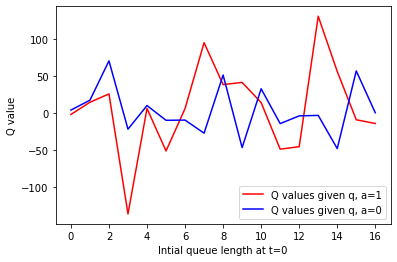

In [12]:
# Plotting simulated Q(w,a) versus w

plt.plot(initial_queue_length_vector[0:17], Q_values_joining_fixed_price, color="red", label = "Q(q,1)")
plt.plot(initial_queue_length_vector[0:17], Q_values_not_joining_fixed_price, color="blue", label = "Q(q,0)")
plt.xlabel("Queue length at t=0")
plt.ylabel("Q value")
plt.legend()
plt.savefig("Q values - fixed price.pdf")

In [ ]:
## Plotting function approximation for Q(w,a) versus w

initial_workload_vector = np.arange(0, 20, 0.01)

approx_Q_values_joining_fixed_price = []
approx_Q_values_not_joining_fixed_price = []

for initial_workload in initial_workload_vector:
    temp_not_joining = -1/(1-joining_probability(initial_workload, price)) * gradient_joining_probability(initial_workload, price)
    temp_joining = gradient_joining_probability(initial_workload, price)/joining_probability(initial_workload, price)
    
    approx_Q_values_not_joining_fixed_price.append(temp_not_joining)
    approx_Q_values_joining_fixed_price.append(temp_joining)

plt.plot(initial_workload_vector, approx_Q_values_joining_fixed_price, color = "red", label = "Approx for Q values given w, a=1")
plt.plot(initial_workload_vector, approx_Q_values_not_joining_fixed_price, color = "blue", label = "Approx for Q values given w, a=0")
plt.xlabel("Intial workload at t=0")
plt.ylabel("Function approx for Q")
plt.legend()
plt.savefig("Approx Q values - fixed price.pdf")

## Studying the map $p \mapsto Q^p(w,a)$ for fixed initial workload $w$ and action $a$.

In [ ]:
lam = 0.8
theta_1 = 0.1
theta_2 = 0.2
s = 1

service_par = 1

initial_workload = 0

In [ ]:
n = 200000
N_runs = 1000

Q_values_joining_fixed_initial_queue_length = []
Q_values_not_joining_fixed_initial_queue_length = []

for price in prices:
    mean_Q_joining = 0
    mean_Q_not_joining = 0
    
    for iter in range(N_runs):
        generate_arrival_process(lam)
        generate_service_times(1)
        
        mean_Q_joining += queue_simulation_1(initial_queue_length, 1, price, price_revenue_dict[price])
        mean_Q_not_joining += queue_simulation_1(initial_queue_length, 0, price, price_revenue_dict[price])
    
    mean_Q_joining = mean_Q_joining/N_runs
    mean_Q_not_joining = mean_Q_not_joining/N_runs
    
    print(price)
    
    Q_values_joining_fixed_initial_queue_length.append(mean_Q_joining)
    Q_values_not_joining_fixed_initial_queue_length.append(mean_Q_not_joining) 

In [ ]:
# Plotting simulated Q(w,a) versus w

plt.plot(prices, Q_values_joining_fixed_initial_queue_length, color="red", label = "Q values given price, a=1")
plt.plot(prices, Q_values_not_joining_fixed_initial_queue_length, color="blue", label = "Q values given price, a=0")
plt.xlabel("Price")
plt.ylabel("Q value")
plt.legend()
plt.savefig("Q values - fixed initial queue length.pdf")

In [ ]:
## Plotting function approximation for Q(w,a) versus w

prices = np.arange(0, 20, 0.01)

approx_Q_values_joining_fixed_initial_workload = []
approx_Q_values_not_joining_fixed_initial_workload = []

for price in prices:
    temp_not_joining = -1/(1-joining_probability(initial_workload, price)) * gradient_joining_probability(initial_workload, price)
    temp_joining = gradient_joining_probability(initial_workload, price)/joining_probability(initial_workload, price)
    
    approx_Q_values_not_joining_fixed_initial_workload.append(temp_not_joining)
    approx_Q_values_joining_fixed_initial_workload.append(temp_joining)

plt.plot(prices, approx_Q_values_joining_fixed_initial_workload, color = "red", label = "Approx for Q values given price, a=1")
plt.plot(prices, approx_Q_values_not_joining_fixed_initial_workload, color = "blue", label = "Approx for Q values given price, a=0")
plt.xlabel("Price")
plt.ylabel("Function approx for Q")
plt.legend()
plt.savefig("Approx Q values - fixed initial workload.pdf")

## Verifying condition (3), Page 1060 from paper by Sutton

In [ ]:
# lam = 0.8
# theta_1 = 0.1
# theta_2 = 0.2
# s = 1
# service_par = 1

# price = 10

# gamma_par = 0.2633643762504345

# n = 200000 # Number of customers per simulation run
# N_runs = 500 # Number of simulations

# Q_values_random_sampling_0 = []
# Q_values_random_sampling_1 = []


# for initial_workload in sampled_states:
#     mean_Q_joining = 0
#     mean_Q_not_joining = 0
    
#     for iter in range(N_runs):
#         generate_arrival_process(lam)
#         generate_service_times(service_par)
        
#         mean_Q_joining += queue_simulation_1(initial_workload, 1, price, theoretical_revenue)
#         mean_Q_not_joining += queue_simulation_1(initial_workload, 0, price, theoretical_revenue)
    
#     mean_Q_joining = mean_Q_joining/N_runs
#     mean_Q_not_joining = mean_Q_not_joining/N_runs
    
#     print(i
    
#     Q_values_random_sampling_1.append(mean_Q_joining)
#     Q_values_random_sampling_0.append(mean_Q_not_joining)

          
# lhs = 0          

# for iter in range(len(sampled_states)):
#     lhs += joining_probability(sampled_states[iter], price) * (Q_values_random_sampling_1[iter] - approx_Q(sampled_states[iter], 1, price, gamma_par))
#           * gradient_approx_Q(sampled_states[iter], 1, price)
#     lhs += (1-joining_probability(sampled_states[iter], price)) * (Q_values_random_sampling_0[iter] - approx_Q(sampled_states[iter], 1, price, gamma_par))
#           * gradient_approx_Q(sampled_states[iter], 0, price)